In [22]:

import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


#### Problem Statement
Research papers are published in large volumes every day, making manual categorization into research domains time-consuming and error-prone.
The objective of this project is to build a Machine Learning model that automatically classifies a research paper abstract into its correct scientific category (such as Computer Vision, Machine Learning, Optics, Quantum Physics, etc.)

In [23]:
import pandas as pd
df = pd.read_csv("C:/Users/shreya/MACHINE LEARNING/arxiv_top10_labels.csv")

In [24]:
df

,abstract,label
0,We performed a rigorous theoretical converge...,physics.optics
1,We propose an extrapolation technique that a...,physics.optics
2,In this manuscript we investigate the capabi...,physics.optics
3,We present a review of the discrete dipole a...,physics.optics
4,"In a quantum mechanical model, Diosi, Feldma...",quant-ph
...,...,...
628403,Inspired by the dissipative quantum model of...,quant-ph
628404,It is shown that the quantum jumps in the ph...,quant-ph
628405,In this paper the idea of holonomic quantum ...,quant-ph
628406,An approach to the solution of NP-complete p...,quant-ph


## Data Cleaning

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628408 entries, 0 to 628407
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   abstract  628408 non-null  object
 1   label     628408 non-null  object
dtypes: object(2)
memory usage: 9.6+ MB


In [26]:
df.isnull().sum()

abstract    0
label       0
dtype: int64

In [27]:
df.duplicated().sum()

198

In [28]:
# Remove duplicated headers inside data
df = df[df["abstract"] != "abstract"]
df = df[df["label"] != "label"]



In [29]:
# Remove duplicate abstracts
df = df.drop_duplicates(subset=["abstract"])

# Reset index
df = df.reset_index(drop=True)



In [30]:
# Strip spaces
df["label"] = df["label"].astype(str).str.strip()


In [31]:

# Keep only first category
df["label"] = df["label"].apply(lambda x: x.split()[0])


In [32]:
# Keep top 10 labels
top_labels = df["label"].value_counts().nlargest(10).index
df = df[df["label"].isin(top_labels)]

print(df["label"].value_counts())

label
cs.CV              137432
cs.LG              121816
cs.CL               74274
cs.IT               38393
cs.RO               35344
physics.optics      34069
cs.AI               32940
cs.CR               30048
math.NA             22914
physics.flu-dyn     22208
Name: count, dtype: int64


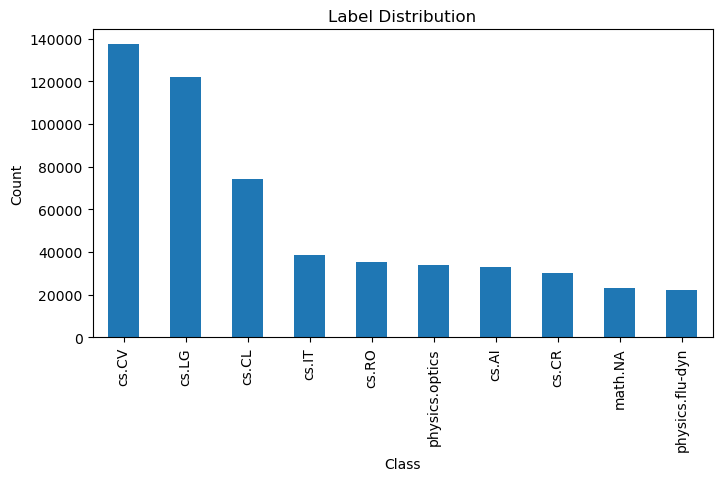

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
df["label"].value_counts().plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [34]:
for i in df.select_dtypes(include=['float64','int64']):
    plt.figure(figsize=(6,4))
    sns.kdeplot(df,x=i,fill=True)
    plt.title(f"Distribution of {i}")
    


## Preprocessing

In [35]:
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV


In [36]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-z ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df["clean_abstract"] = df["abstract"].apply(clean_text)


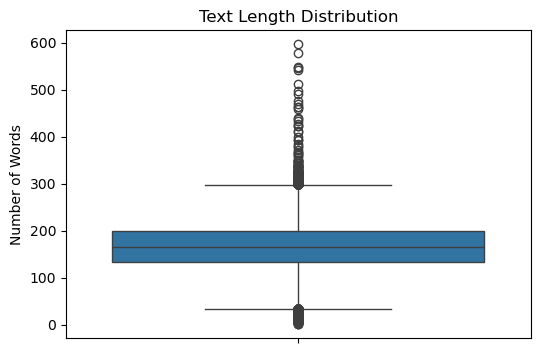

In [37]:
df["text_length"] = df["clean_abstract"].apply(lambda x: len(x.split()))
import seaborn as sns
plt.figure(figsize=(6,4))
sns.boxplot(y=df["text_length"])
plt.title("Text Length Distribution")
plt.ylabel("Number of Words")
plt.show()

### Defining Target Variable

In [38]:
from sklearn.model_selection import train_test_split

X = df["clean_abstract"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(439550,)
(109888,)
(439550,)
(109888,)


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import TruncatedSVD


## KNN CLASSIFIER

#### Why SVD?
 - KNN cannot handle sparse high-dimensional vectors
 - SVD converts them into dense low-dimension vectors

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

knn_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,
        stop_words="english"
    )),
    ("svd", TruncatedSVD(n_components=100, random_state=42)),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,
        metric="euclidean"
    ))
])


#### Train

In [41]:
knn_pipe.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('svd', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


#### Predict

In [42]:
y_pred_knn = knn_pipe.predict(X_test)


In [43]:
from sklearn.metrics import accuracy_score


In [44]:
acc_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", acc_knn)


KNN Accuracy: 0.7889396476412347


## Evaluate KNN

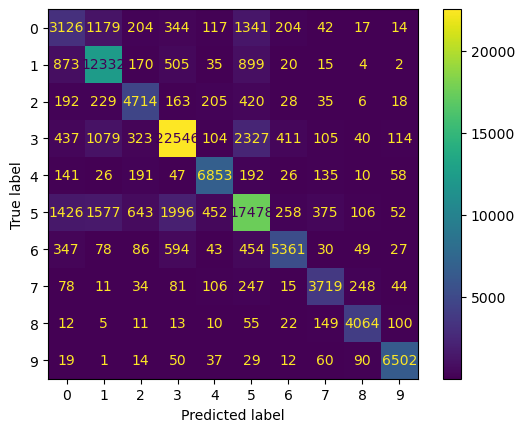

In [45]:
## # Displays the confusion matrix to visualize correct and incorrect predictions
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [46]:
## Classification Report

 ### LogisticRegression

In [47]:
from sklearn.linear_model import LogisticRegression
logreg_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])
logreg_pipe.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [48]:
y_pred = logreg_pipe.predict(X_test)

In [49]:
acc_logreg = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc_logreg)


Logistic Regression Accuracy: 0.8659635264997088


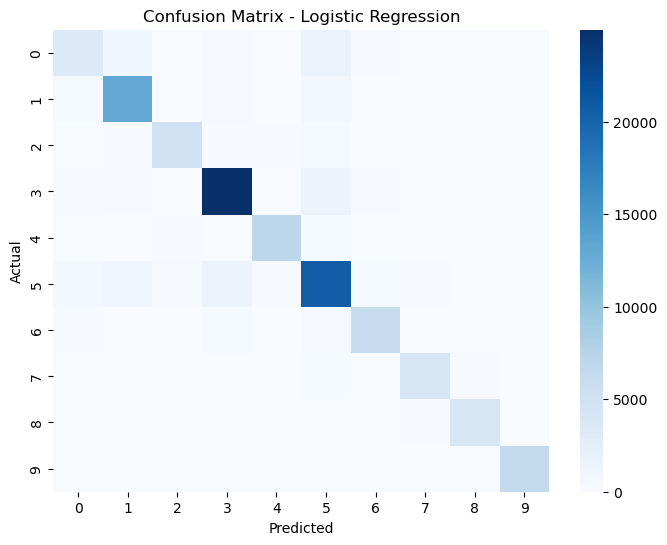

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Naive Bayes

In [51]:
from sklearn.naive_bayes import MultinomialNB

nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        stop_words="english"
    )),
    ("clf", MultinomialNB())
])

nb_pipe.fit(X_train, y_train)

y_pred_nb = nb_pipe.predict(X_test)




In [52]:
acc_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", acc_nb)


Naive Bayes Accuracy: 0.8329753931275481


In [53]:
print(classification_report(y_test, y_pred_nb))

                 precision    recall  f1-score   support

          cs.AI       0.66      0.43      0.52      6588
          cs.CL       0.80      0.87      0.84     14855
          cs.CR       0.84      0.81      0.82      6010
          cs.CV       0.88      0.87      0.87     27486
          cs.IT       0.93      0.89      0.91      7679
          cs.LG       0.75      0.82      0.78     24363
          cs.RO       0.85      0.81      0.83      7069
        math.NA       0.85      0.86      0.85      4583
physics.flu-dyn       0.94      0.92      0.93      4441
 physics.optics       0.97      0.97      0.97      6814

       accuracy                           0.83    109888
      macro avg       0.85      0.82      0.83    109888
   weighted avg       0.83      0.83      0.83    109888



In [54]:
from sklearn.metrics import accuracy_score

accuracy_results = {
    "KNN Accuracy (%)": round(accuracy_score(y_test, y_pred_knn) * 100, 2),
    "Logistic Regression Accuracy (%)": round(accuracy_score(y_test, y_pred) * 100, 2),
    "Naive Bayes Accuracy (%)": round(accuracy_score(y_test, y_pred_nb) * 100, 2)
}

accuracy_results


{'KNN Accuracy (%)': 78.89,
 'Logistic Regression Accuracy (%)': 86.6,
 'Naive Bayes Accuracy (%)': 83.3}

In [55]:
print("KNN Accuracy               :", accuracy_score(y_test, y_pred_knn) * 100)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred) * 100)
print("Naive Bayes Accuracy        :", accuracy_score(y_test, y_pred_nb) * 100)


KNN Accuracy               : 78.89396476412347
Logistic Regression Accuracy: 86.59635264997088
Naive Bayes Accuracy        : 83.29753931275481


In [56]:
pip install joblib


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


In [58]:
import joblib

joblib.dump(logreg_pipe, "_MLProject2_.joblib")


['_MLProject2_.joblib']